In [86]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import pandas as pd
import pandas as pd
import matplotlib.patches as mpatches
import seaborn as sns

In [87]:
import glob
from dask.diagnostics import ProgressBar
static_fields = xr.open_dataset(r'/nesi/project/niwa03712/group_shared/Emulator_training_data/ERA5_eval_ccam_12km.198110_NZ_Invariant.nc')

## Creating Figure 3 and Figure 2
1. Load Annual maxima dataset (see create_annual_maximum_for_figure4.ipynb)


## Loading the High-resolution downscaled fields

In [88]:
import os
AI_indicators = xr.open_dataset(r'/nesi/project/niwa00018/ML_downscaling_CCAM/AI_large_ensemble/NIWA-REMS_AI_P_T_indicators_final_v150425.nc')
AI_indicators['CC_signal'] =100* ( AI_indicators.seasonal_pr_future - AI_indicators.seasonal_pr_hist)/AI_indicators.seasonal_pr_hist

AI_indicators['CC_signal_tasmax'] =( AI_indicators.seasonal_tasmax_future - AI_indicators.seasonal_tasmax_hist)#/AI_indicators.seasonal_pr_hist
access_esm = AI_indicators.sel(GCM_variant = AI_indicators.GCM =='ACCESS-ESM1-5')

### Creating a Dataset that computes the Climate Change Signal for ACCESS-ESM1-5 (ensemble) and the CanESM5 Climate Change Signal

In [89]:
canesm = AI_indicators.sel(GCM_variant = AI_indicators.GCM =='CanESM5')
canesm_rolling = canesm.rolling(year =10, min_periods =1).max().rolling(year =10).mean()
access_esm_rolling = access_esm .rolling(year =10, min_periods =1).max().rolling(year =10).mean()
canesm_hist = canesm_rolling.sel(year = slice(1986, 2005)).mean("year")
canesm_future = canesm_rolling.sel(year = slice(2080, 2099)).mean("year")
access_hist = access_esm_rolling .sel(year = slice(1986, 2005)).mean("year")
access_future = access_esm_rolling .sel(year = slice(2080, 2099)).mean("year")

Climate Change Signal computation

In [67]:
canesm_future_rx10 = (100 *(canesm_future - canesm_hist) / canesm_hist).Rx1day
canesm_future_tx10 = ((canesm_future - canesm_hist)).TXx

## Supplementary Plot on CanESM5 Ensemble Variance + Climate Change Signal

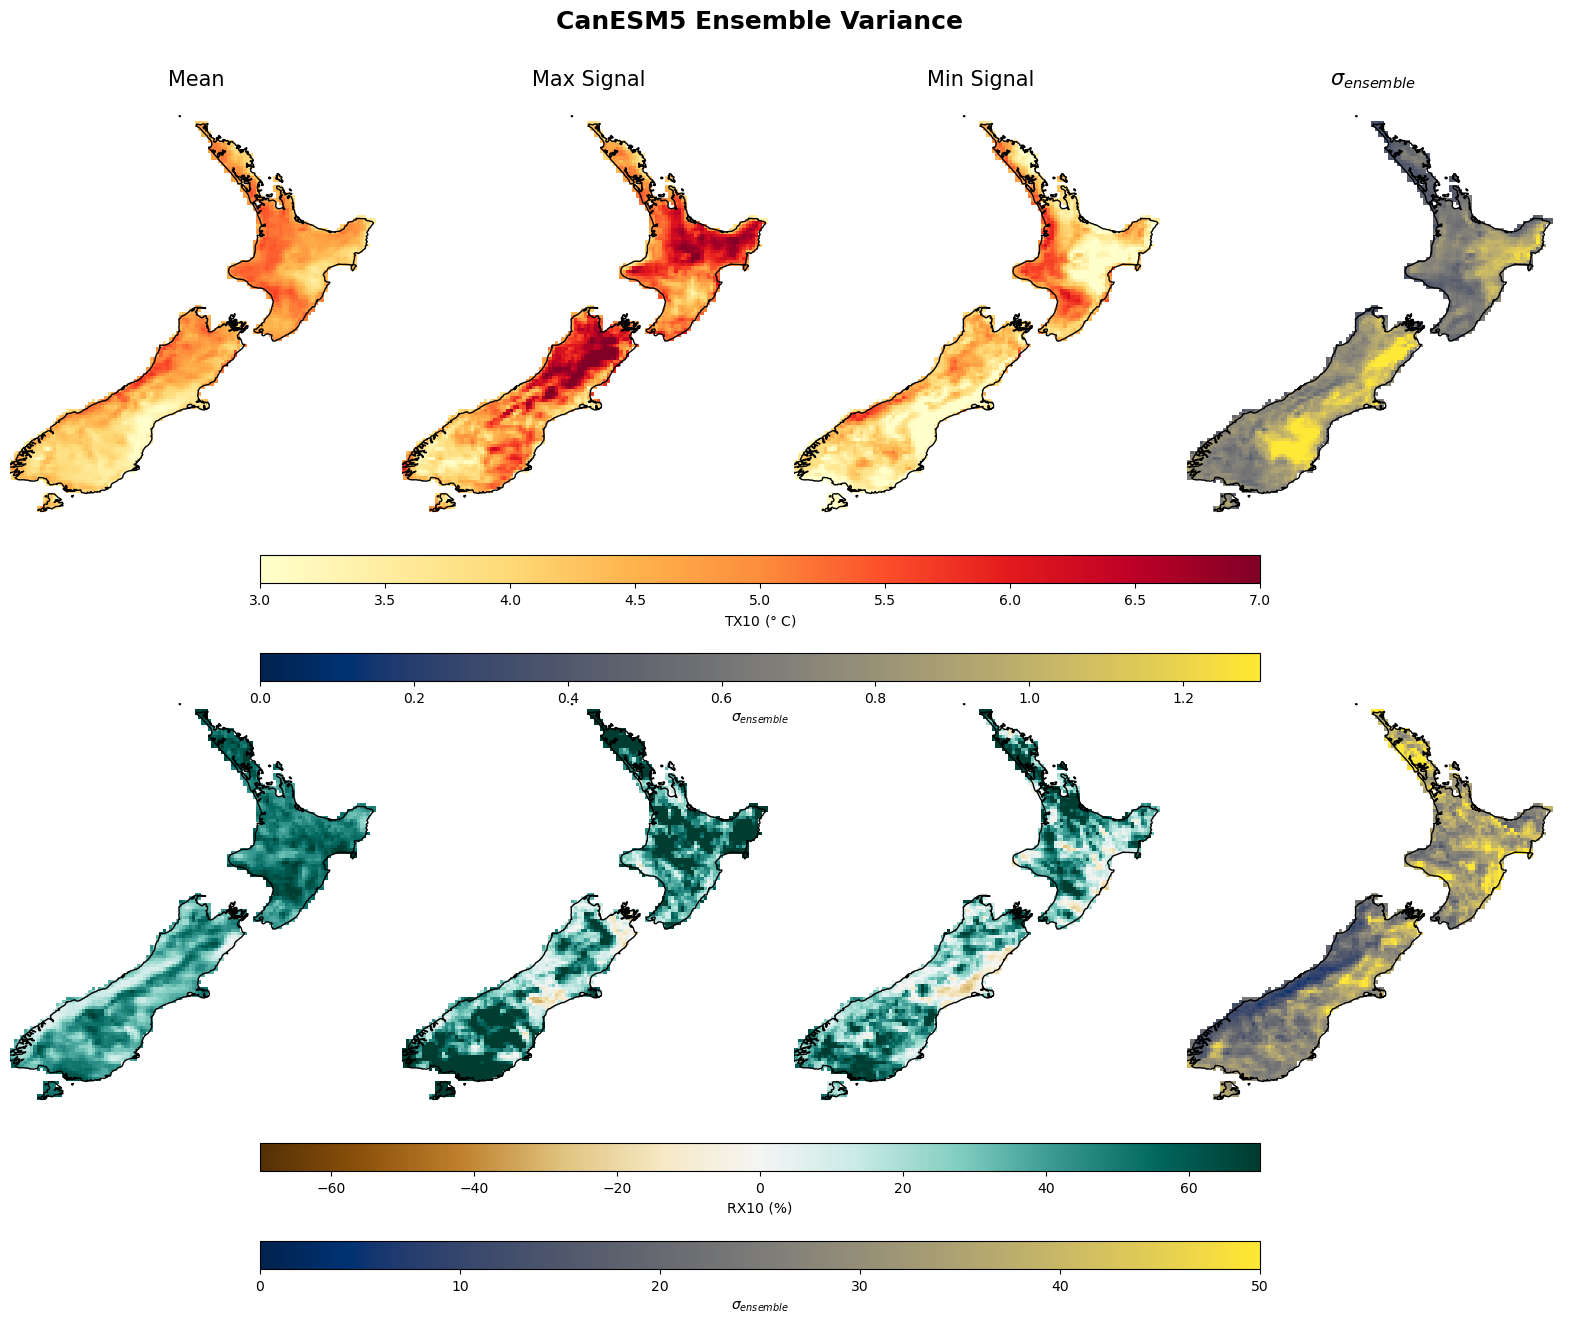

In [85]:
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import numpy as np

# Assume these are your input DataArrays
# canesm_future_tx10: (GCM_variant, lat, lon)
# canesm_future_rx10: (GCM_variant, lat, lon)

def get_extremes(data):
    # Get mean
    mean = data.mean(dim='GCM_variant')
    var = data.std(dim='GCM_variant')

    # Area-averaged value across each variant
    area_mean = data.where(static_fields.orog>0, np.nan).mean(dim=['lat', 'lon'])

    # Get max and min variant index
    max_idx = np.nanargmax(area_mean.values)#area_mean.argmax(dim='GCM_variant').item()
    min_idx = np.nanargmin(area_mean.values)

    max_variant = data.isel(GCM_variant=max_idx)
    min_variant = data.isel(GCM_variant=min_idx)

    return mean, max_variant, min_variant, var

# Get data for tx10 and rx10
tx10_mean, tx10_max, tx10_min, tx10_std = get_extremes(canesm_future_tx10)
rx10_mean, rx10_max, rx10_min, rx10_std = get_extremes(canesm_future_rx10)

# Plot
# ... [your existing imports, get_extremes, and data loading remain the same] ...

# Define figure
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(20, 14),
                         subplot_kw={'projection': ccrs.PlateCarree(central_longitude=171.77)},
                         gridspec_kw={'hspace': 0.2, 'wspace': 0.05})

titles = ['Mean', 'Max Signal', 'Min Signal', '$\sigma_{ensemble}$']
data_rows = [(tx10_mean, tx10_max, tx10_min, tx10_std),
             (rx10_mean, rx10_max, rx10_min, rx10_std)]

# For storing std image handles
std_im = [None, None]

for row in range(2):
    for col in range(4):
        ax = axes[row, col]
        data = data_rows[row][col]

        # Determine colormap and range
        if col == 3:  # ensemble std column
            cmap = 'cividis'
            vmin, vmax = (0, 1.3) if row == 0 else (0, 50)
        else:
            cmap = 'YlOrRd' if row == 0 else 'BrBG'
            vmin, vmax = (3, 7) if row == 0 else (-70, 70)
        if col<3:
            im1 = data.where(static_fields.orog > 0, np.nan).plot(
                ax=ax,
                transform=ccrs.PlateCarree(),
                add_colorbar=False,
                cmap=cmap,
                vmin=vmin,
                vmax=vmax
            )

        if col == 3:
            im = data.where(static_fields.orog > 0, np.nan).plot(
                ax=ax,
                transform=ccrs.PlateCarree(),
                add_colorbar=False,
                cmap=cmap,
                vmin=vmin,
                vmax=vmax
            )
            std_im[row] = im  # Store std image handle for second colorbar

        ax.coastlines()
        ax.set_title(titles[col] if row == 0 else "", fontsize=15)
        ax.set_frame_on(False)
        ax.set_extent([166.5, 178.9, -47.8, -33.4], crs=ccrs.PlateCarree())

    # First colorbar (mean/max/min)
    cbar_ax_main = fig.add_axes([0.25, 0.09 if row == 1 else 0.51, 0.5, 0.02])
    plt.colorbar(im1, cax=cbar_ax_main, orientation='horizontal',
                 label='TX10 ($\degree$ C)' if row == 0 else 'RX10 (%)')

    # Second colorbar (ensemble std)
    cbar_ax_std = fig.add_axes([0.25, 0.02 if row == 1 else 0.44, 0.5, 0.02])
    plt.colorbar(std_im[row], cax=cbar_ax_std, orientation='horizontal',
                 label='$\sigma_{ensemble}$')

fig.suptitle('CanESM5 Ensemble Variance', fontsize=18, x =0.5, y =0.92, weight ='bold')
plt.show()
fig.savefig(r'/nesi/project/niwa00018/ML_downscaling_CCAM/AI_large_ensemble/figures/CanESM5_ensemble_variance.png', dpi =500, bbox_inches ='tight')


## Creating Figure 3

First loading the low-resolution ACCESS-ESM1-5 data, then computing the climate change signal etc

In [3]:
# Loading the low-resolution ACCESS-ESM1-5 ensemble
merged_dset_updated = xr.open_dataset(r'/nesi/project/niwa00018/ML_downscaling_CCAM/AI_large_ensemble/Low_res_ACCESS-ESM1-5_ensemble.nc')
merged_dset = merged_dset_updated.copy()
merged_dset['CC_signal_pr'] = 100*(merged_dset['pr_seasonal_future'] -merged_dset['pr_seasonal_hist'])/merged_dset['pr_seasonal_hist']
#merged_dset= merged_dset.interp(lat = static_fields.lat, lon = static_fields.lon, method ='nearest')

In [95]:
merged_dset['CC_signal_tasmax'] = (merged_dset['tasmax_seasonal_future'] -merged_dset['tasmax_seasonal_hist'])#/merged_dset['pr_seasonal_hist']
merged_dset= merged_dset.interp(lat = static_fields.lat, lon = static_fields.lon, method ='nearest')

In [96]:
hist_signal = merged_dset.Rx1day.sel(year =slice(1986, 2005)).mean("year")
future_signal = merged_dset.Rx1day.sel(year =slice(2080, 2099)).mean("year")
cc_signal = 100 * (future_signal - hist_signal)/hist_signal

In [97]:
hist_signal_v2 = merged_dset.Rx1day.rolling(year =10).max().sel(year =slice(1986, 2005)).mean("year")
future_signal_v2 = merged_dset.Rx1day.rolling(year =10).max().sel(year =slice(2080, 2099)).mean("year")
cc_signal_v2 = 100 * (future_signal_v2 - hist_signal_v2)/hist_signal_v2

In [98]:
hist_signal_txx = merged_dset.TXx.sel(year =slice(1986, 2005)).mean("year")
future_signal_txx = merged_dset.TXx.sel(year =slice(2080, 2099)).mean("year")
cc_signal_txx = (future_signal_txx  - hist_signal_txx )#/hist_signal

In [99]:
hist_signal_txx_v2 = merged_dset.TXx.rolling(year =10).max().sel(year =slice(1986, 2005)).mean("year")
future_signal_txx_v2 = merged_dset.TXx.rolling(year =10).max().sel(year =slice(2080, 2099)).mean("year")
cc_signal_txx_v2 = (future_signal_txx_v2  - hist_signal_txx_v2 )#/hist_signal

In [100]:
hist_signal_txx = merged_dset.tasmax_seasonal_hist
future_signal_txx = merged_dset.tasmax_seasonal_future
cc_signal_tasmax_gcm = (future_signal_txx  - hist_signal_txx )#/hist_signal

In [101]:

hist_signal_em = access_esm.Rx1day.sel(year =slice(1986, 2005)).mean("year")
future_signal_em = access_esm.Rx1day.sel(year =slice(2080, 2099)).mean("year")
cc_signal_em = 100 * (future_signal_em - hist_signal_em)/hist_signal_em

In [102]:

hist_signal_em_canesm = canesm.Rx1day.sel(year =slice(1986, 2005)).mean("year")
future_signal_em_canesm = canesm.Rx1day.sel(year =slice(2080, 2099)).mean("year")
cc_signal_em_canesm = 100 * (future_signal_em_canesm - hist_signal_em_canesm)/hist_signal_em_canesm

In [103]:

hist_signal_em_v2 = access_esm.Rx1day.rolling(year =10).max().sel(year =slice(1986, 2005)).mean("year")
future_signal_em_v2 = access_esm.Rx1day.rolling(year =10).max().sel(year =slice(2080, 2099)).mean("year")
cc_signal_em_v2 = 100 * (future_signal_em_v2 - hist_signal_em_v2)/hist_signal_em_v2

In [104]:

hist_signal_em_canesm_v2 = canesm.Rx1day.rolling(year =10).max().sel(year =slice(1986, 2005)).mean("year")
future_signal_em_canesm_v2 = canesm.Rx1day.rolling(year =10).max().sel(year =slice(2080, 2099)).mean("year")
cc_signal_em_canesm_v2 = 100 * (future_signal_em_canesm_v2 - hist_signal_em_canesm_v2) / hist_signal_em_canesm_v2

In [105]:
hist_signal_em_txx = access_esm.TXx.sel(year =slice(1986, 2005)).mean("year")
future_signal_em_txx = access_esm.TXx.sel(year =slice(2080, 2099)).mean("year")
cc_signal_em_txx = (future_signal_em_txx - hist_signal_em_txx)#/hist_signal_em

In [106]:
hist_signal_em_txx_v2 = access_esm.TXx.rolling(year =10).max().sel(year =slice(1986, 2005)).mean("year")
future_signal_em_txx_v2 = access_esm.TXx.rolling(year =10).max().sel(year =slice(2080, 2099)).mean("year")
cc_signal_em_txx_v2 = (future_signal_em_txx_v2 - hist_signal_em_txx_v2)#/hist_signal_em

## Loading the Ground Truth Climate Change SIgnal

In [108]:
ccam_historical = xr.open_dataset(r'/nesi/project/niwa00018/ML_downscaling_CCAM/AI_large_ensemble/CCAM_P_T_indicators_final.nc')

In [110]:

hist_signal_ccam = ccam_historical.Rx1day.sel(year =slice(1986, 2005)).mean("year")
future_signal_ccam = ccam_historical.Rx1day.sel(year =slice(2080, 2099)).mean("year")
cc_signal_ccam = 100 * (future_signal_ccam - hist_signal_ccam)/hist_signal_ccam

In [111]:

hist_signal_ccam_v2 = ccam_historical.Rx1day.rolling(year =10).max().sel(year =slice(1986, 2005)).mean("year")
future_signal_ccam_v2 = ccam_historical.Rx1day.rolling(year =10).max().sel(year =slice(2080, 2099)).mean("year")
cc_signal_ccam_v2 = 100 * (future_signal_ccam_v2 - hist_signal_ccam_v2)/hist_signal_ccam_v2

In [112]:
hist_signal_ccam_txx = ccam_historical.TXx.sel(year =slice(1986, 2005)).mean("year")
future_signal_ccam_txx = ccam_historical.TXx.sel(year =slice(2080, 2099)).mean("year")
cc_signal_ccam_txx = (future_signal_ccam_txx - hist_signal_ccam_txx)#/hist_signal_ccam

In [113]:
hist_signal_ccam_txx = ccam_historical.TXx.rolling(year =10).max().sel(year =slice(1986, 2005)).mean("year")
future_signal_ccam_txx = ccam_historical.TXx.rolling(year =10).max().sel(year =slice(2080, 2099)).mean("year")
cc_signal_ccam_txx_v2 = (future_signal_ccam_txx - hist_signal_ccam_txx)#/hist_signal_ccam

In [114]:

hist_signal_ccam = ccam_historical.seasonal_tasmax_hist
future_signal_ccam = ccam_historical.seasonal_tasmax_future
cc_signal_ccam_tasmax =  (future_signal_ccam - hist_signal_ccam)#/hist_signal_ccam

In [115]:
hist_signal_ccam_txx = ccam_historical.TXx.sel(year =slice(1986, 2005)).mean("year")
future_signal_ccam_txx = ccam_historical.TXx.sel(year =slice(2080, 2099)).mean("year")
cc_signal_ccam_txx = (future_signal_ccam_txx - hist_signal_ccam_txx)#/hist_signal_ccam

In [116]:
list_of_gcms = ['CNRM-CM6-1_r1i1p1f2', 'UKESM1-0-LL_r1i1p1f2',
       'GISS-E2-1-G_r1i1p1f2', 'IITM-ESM_r1i1p1f1', 'CanESM5_r1i1p1f1',
       'INM-CM5-0_r1i1p1f1', 'INM-CM4-8_r1i1p1f1', 'TaiESM1_r1i1p1f1',
       'EC-Earth3-Veg-LR_r1i1p1f1', 'EC-Earth3_r1i1p1f1',
       'EC-Earth3-Veg_r1i1p1f1', 'CMCC-ESM2_r1i1p1f1', 'CMCC-CM2-SR5_r1i1p1f1',
       'ACCESS-ESM1-5_r1i1p1f1', 'ACCESS-CM2_r4i1p1f1', 'IPSL-CM6A-LR_r1i1p1f1',
       'NorESM2-LM_r1i1p1f1', 'NorESM2-MM_r1i1p1f1', 'MPI-ESM1-2-LR_r1i1p1f1',
       'MPI-ESM1-2-HR_r1i1p1f1']

In [117]:
multi_model_ensemble = AI_indicators.sel(GCM_variant = list_of_gcms)

hist_signal_mme = multi_model_ensemble.Rx1day.sel(year =slice(1986, 2005)).mean("year")
future_signal_mme = multi_model_ensemble.Rx1day.sel(year =slice(2080, 2099)).mean("year")
cc_signal_mme = 100 * (future_signal_mme - hist_signal_mme)/hist_signal_mme

In [118]:
multi_model_ensemble = AI_indicators.sel(GCM_variant = list_of_gcms)

hist_signal_mme_v2 = multi_model_ensemble.Rx1day.rolling(year =10).max().sel(year =slice(1986, 2005)).mean("year")
future_signal_mme_v2 = multi_model_ensemble.Rx1day.rolling(year =10).max().sel(year =slice(2080, 2099)).mean("year")
cc_signal_mme_v2 = 100 * (future_signal_mme_v2 - hist_signal_mme_v2)/hist_signal_mme_v2

In [119]:
#multi_model_ensemble = AI_indicators.sel(GCM_variant = list_of_gcms)

hist_signal_mme_txx = multi_model_ensemble.TXx.sel(year =slice(1986, 2005)).mean("year")
future_signal_mme_txx = multi_model_ensemble.TXx.sel(year =slice(2080, 2099)).mean("year")
cc_signal_mme_txx = (future_signal_mme_txx - hist_signal_mme_txx)#/hist_signal_mme

In [120]:

hist_signal_mme_txx = multi_model_ensemble.seasonal_tasmax_hist
future_signal_mme_txx = multi_model_ensemble.seasonal_tasmax_future
cc_signal_mme_tasmax = (future_signal_mme_txx - hist_signal_mme_txx)#/hist_signal_mme

In [121]:
static_fields = xr.open_dataset(r'/nesi/project/niwa03712/group_shared/Emulator_training_data/ERA5_eval_ccam_12km.198110_NZ_Invariant.nc')

In [37]:
# stippling_mask = np.where(agreement.where(static_fields.orog > 0, np.nan) < threshold)

In [122]:
import numpy as np

def create_df(lat, lon, season ='DJF'):
    df1 = pd.DataFrame()
    # V1
    
    access_arr = cc_signal_em_v2.interp(lat=lat, lon=lon).values.flatten()
    df1.loc[:len(access_arr)-1, '    GAN \nACCESS-ESM1-5 \n   (n=40)'] = access_arr
    df1['Metric'] = 'Rx[10 year]'
    df1 = df1.melt(var_name="GCM Variant", value_name="CC Signal", id_vars=["Metric"])
    
    df2 = pd.DataFrame()
    #V2
    access_seasonal =  cc_signal_em.interp(lat=lat, lon=lon).values.flatten()
    df2.loc[:len(access_seasonal)-1  , '    GAN \nACCESS-ESM1-5 \n   (n=40)'] = access_seasonal
    df2['Metric'] = 'Rx1Day'
    df2 = df2.melt(var_name="GCM Variant", value_name="CC Signal", id_vars=["Metric"])
    
    # V3
    df3 = pd.DataFrame()
    other_gcms = cc_signal_mme_v2.interp(lat=lat, lon=lon).values.flatten()
    df3.loc[:len(other_gcms)-1, "GAN \nCMIP6 \n(n=18)"] = other_gcms
    df3['Metric'] = 'Rx[10 year]'
    df3 = df3.melt(var_name="GCM Variant", value_name="CC Signal", id_vars=["Metric"])
    
    # V4
    df4 = pd.DataFrame()
    other_gcms = cc_signal_mme.interp(lat=lat, lon=lon).values.flatten()
    df4.loc[:len(other_gcms)-1, "GAN \nCMIP6 \n(n=18)"] = other_gcms
    df4['Metric'] = 'Rx1Day'
    df4 = df4.melt(var_name="GCM Variant", value_name="CC Signal", id_vars=["Metric"])
    
    # V5
    df5 = pd.DataFrame()
    canesm_arr = cc_signal_v2.interp(lat=lat, lon=lon).values.flatten()
    df5.loc[:len(canesm_arr)-1, '  Raw \nACCESS-ESM1-5 \n   (n=40)'] = canesm_arr
    df5['Metric'] = 'Rx[10 year]'
    df5 = df5.melt(var_name="GCM Variant", value_name="CC Signal", id_vars=["Metric"])
    #V6
    
    df6 = pd.DataFrame()
    canesm_arr2 = cc_signal.interp(lat=lat, lon=lon).values.flatten()
    df6.loc[:len(canesm_arr2)-1, '  Raw \nACCESS-ESM1-5 \n   (n=40)'] = canesm_arr2
    df6['Metric'] = 'Rx1Day'
    df6 = df6.melt(var_name="GCM Variant", value_name="CC Signal", id_vars=["Metric"])
    
    df7 = pd.DataFrame()
    ccam_arr = cc_signal_ccam_v2.interp(lat=lat, lon=lon).values.flatten()
    df7.loc[:len(ccam_arr)-1, 'CCAM \n(n=6)'] = ccam_arr
    df7['Metric'] = 'Rx[10 year]'
    df7 = df7.melt(var_name="GCM Variant", value_name="CC Signal", id_vars=["Metric"])
    
    df8 = pd.DataFrame()
    ccam_arr =  cc_signal_ccam.interp(lat=lat, lon=lon).values.flatten()
    df8.loc[:len(ccam_arr)-1, 'CCAM \n(n=6)'] = ccam_arr
    df8['Metric'] = 'Rx1Day'
    df8 = df8.melt(var_name="GCM Variant", value_name="CC Signal", id_vars=["Metric"])
    
    df = pd.concat([df1, df2, df5, df6,df3,df4, df7,df8])
    

    return df

In [123]:

regions = {'Auckland': (-36.7928, 174.6131),
 'Wellington': (-41.2924, 174.7787),
 'Christchurch': (-43.5320, 172.6366)}

#offset_lat = [0.0,0.0 

In [124]:
# forest_green = "#228B22"
grass_light = "#A8E063"  # Slightly lighter grass green for DJF rainfall
forest_green = "#1E6B19"  # Slightly darker forest green for RX1Day

cb_colors  = ["#1E6B19","#A8E063" ]

In [125]:
import matplotlib.patches as mpatches

In [126]:
from matplotlib.colors import LinearSegmentedColormap
import earthpy.spatial as es
hillshade_dset = xr.open_dataset(r'/nesi/project/niwa00018/gibsonp/dload_data/global_topo_1km/topo_NZ_1km.nc')
hillshade = es.hillshade(hillshade_dset.topo.values, azimuth=0, altitude=45)
hillshade_dset['hillshade'] = (('Y','X'), hillshade)


#fig.savefig(r'/nesi/project/niwa00018/ML_downscaling_CCAM/AI_large_ensemble/Rx1day_spatial_figre_dfj.pdf', dpi =500, bbox_inches ='tight')
regions = {'Auckland': (-36.7928, 174.6131),
 'Christchurch': (-43.532, 172.6366)}
import numpy as np
import cartopy.feature as cfeature
from matplotlib.colors import LinearSegmentedColormap

# Define custom colormap colors (approximated from the image)
colors = [    # Slightly lighter green
    (0.0,  "yellowgreen"), # Yellowish green
    (0.25,  "yellow"),     # Bright yellow
    (0.5, "orange"),     # Warm orange
    (0.75,  "saddlebrown"), # Reddish-brown
    (1.0,  "white")       # Lightest color on the far right
]

# Create the colormap
custom_cmap = LinearSegmentedColormap.from_list("custom_colormap", colors)


/home/rampaln/.local/lib/python3.8/site-packages/pandas/core/indexing.py:719: FutureWarning: Slicing a positional slice with .loc is not supported, and will raise TypeError in a future version.  Use .loc with labels or .iloc with positions instead.
  indexer = self._get_setitem_indexer(key)
/home/rampaln/.local/lib/python3.8/site-packages/pandas/core/indexing.py:719: FutureWarning: Slicing a positional slice with .loc is not supported, and will raise TypeError in a future version.  Use .loc with labels or .iloc with positions instead.
  indexer = self._get_setitem_indexer(key)
/nesi/project/niwa00018/rampaln/envs/ml_env_v2/lib/python3.8/site-packages/cartopy/mpl/style.py:76: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '


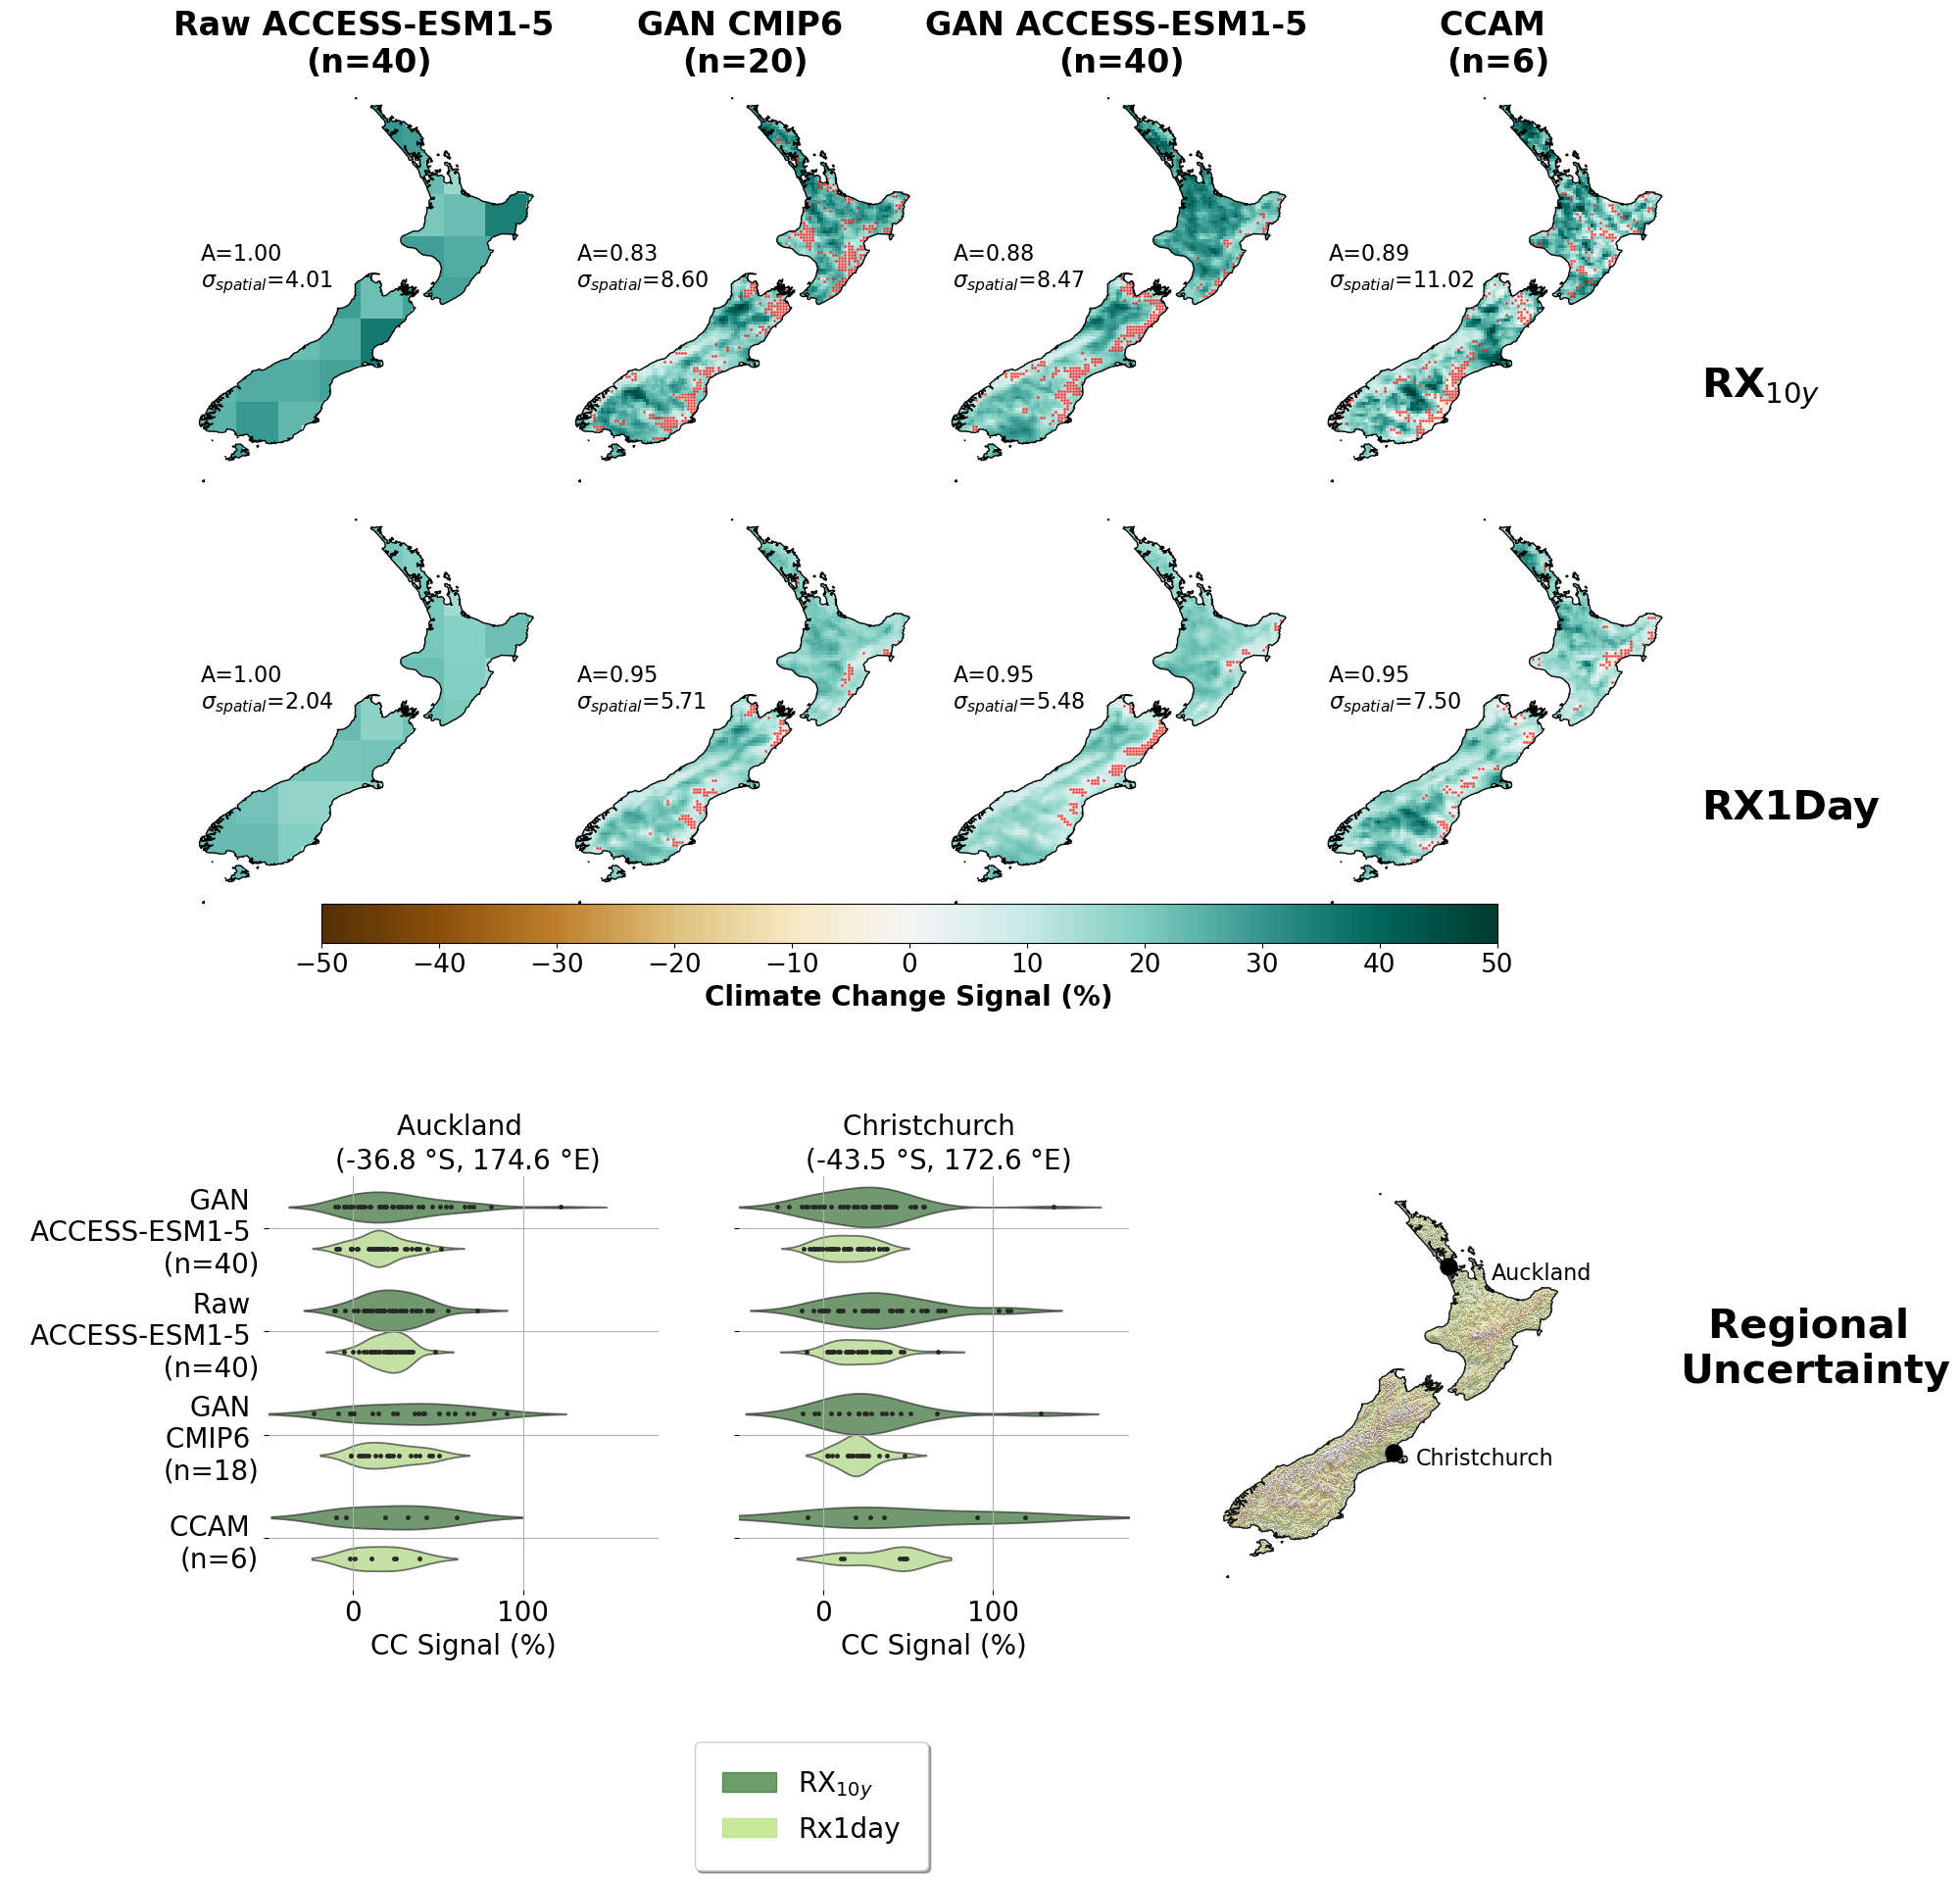

In [128]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import numpy as np
import cartopy.crs as ccrs
import cartopy.feature as cfeature

fig = plt.figure(figsize=(20, 20))
gs = gridspec.GridSpec(18, 16, wspace=-0.13, hspace=0.1)
projections = dict(projection=ccrs.PlateCarree(central_longitude=171.77))

ax0 = fig.add_subplot(gs[:5, 0:4], **projections)
ax1 = fig.add_subplot(gs[:5, 4:8], **projections)
ax2 = fig.add_subplot(gs[:5, 8:12], **projections)
ax3 = fig.add_subplot(gs[:5, 12:16], **projections)
axes = [ax0, ax1, ax2, ax3]

ax3.text(180,-45, 'RX$_{10y}$', weight ='bold', fontsize =30, rotation =0, transform = ccrs.PlateCarree())

ax00 = fig.add_subplot(gs[5:10, 0:4], **projections)
ax11 = fig.add_subplot(gs[5:10, 4:8], **projections)
ax22 = fig.add_subplot(gs[5:10, 8:12], **projections)
ax33 = fig.add_subplot(gs[5:10, 12:16], **projections)

ax33.text(180,-45, 'RX1Day', weight ='bold', fontsize =30, rotation =0, transform = ccrs.PlateCarree())
axes_ = [ax00, ax11, ax22, ax33]
vmin, vmax = -50, 50
levels = np.arange(vmin, vmax + 0.5, 0.5)
threshold = 4/6
total_land_pixels = (static_fields.orog > 0).sum().values

# Helper function to plot maps and stippling
def plot_panel(ax, signal, title, groupby, cmap='BrBG'):
    mean_signal = signal.mean(groupby).where(static_fields.orog > 0, np.nan)
    spatial_variance = mean_signal.stack(z = ['lat','lon']).std("z").values
    cs = mean_signal.plot(ax=ax, transform=ccrs.PlateCarree(), 
                              add_colorbar=False, levels=levels, cmap=cmap)
    #ax.coastlines('10m')
    ax.set_frame_on(False)
    ax.set_title(title, weight='bold', fontsize =24)
    ax.add_feature(cfeature.OCEAN.with_scale('10m'),ec ='k', fc ='white', zorder =12)


    agreement = (signal > 0).sum(groupby[0]) / signal[groupby[0]].size
    agreement2 = (signal <= 0).sum(groupby[0]) / signal[groupby[0]].size
    agreement = xr.concat([agreement, agreement2], dim ="axes").max("axes")
    stippling_mask = np.where(agreement.where(static_fields.orog > 0, np.nan) < threshold)
    lons, lats = np.meshgrid(signal.lon, signal.lat)
    ax.scatter(lons[stippling_mask], lats[stippling_mask], color='r', s=4.0, 
               transform=ccrs.PlateCarree(), alpha=0.7, linewidth=0)
    A = len(stippling_mask[0]) / total_land_pixels
    ax.text(166.5, -41, f'A={"%.2f" % (1-A)}\n' + '$\sigma_{spatial}$'+ f'={"%.2f" % spatial_variance}', transform=ccrs.PlateCarree(), fontsize=16, zorder =13)
    ax.set_extent([166.25, 179, -48.5, -33.5], crs=ccrs.PlateCarree())
    return cs
# Plotting each panel
plot_panel(axes[0], cc_signal_v2, 'Raw ACCESS-ESM1-5 \n(n=40)', ['GCM_variant'])
plot_panel(axes[1], cc_signal_mme_v2, 'GAN CMIP6 \n(n=20)', ['GCM_variant'])
plot_panel(axes[2], cc_signal_em_v2, 'GAN ACCESS-ESM1-5 \n(n=40)', ['GCM_variant'])
cs = plot_panel(axes[3], cc_signal_ccam_v2, 'CCAM \n(n=6)', ['GCM'])


plot_panel(axes_[0], cc_signal, '', ['GCM_variant'])
plot_panel(axes_[1], cc_signal_mme, '', ['GCM_variant'])
plot_panel(axes_[2], cc_signal_em, '', ['GCM_variant'])
cs = plot_panel(axes_[3], cc_signal_ccam, '', ['GCM'])
ax4 = fig.add_axes([0.2, 0.44, 0.6, 0.02])
cbar = fig.colorbar(cs, cax = ax4, orientation ='horizontal')
cbar.set_label('Climate Change Signal (%)', weight ='bold', fontsize =20)
cbar.set_ticks(np.arange(-50, 60, 10))
cbar.ax.tick_params(labelsize =19)
# Set shared extent for last panel
ax00_ = fig.add_subplot(gs[13:, 1:5])
ax11_ = fig.add_subplot(gs[13:, 6:10])
ax22_ = fig.add_subplot(gs[13:, 11:15], **projections)
#ax33_ = fig.add_subplot(gs[12:, 12:15])


axes__ = [ax00_, ax11_]#, ax33_]
index =0
for region, (lat, lon) in regions.items():
    df = create_df(lat, lon)
    ax_violin = axes__[index]

#     sns.boxplot(
# data=df.reset_index(), y="GCM Variant", x="CC Signal",
# ax=ax_violin, palette=cb_colors, hue ="Metric", legend = False
# )
        
    sns.violinplot(
    data=df.reset_index(), y="GCM Variant", x="CC Signal",
    ax=ax_violin, palette=cb_colors,alpha =0.65, inner ='point', hue ="Metric", legend = False, split =False
)#inner="box"
    #sns.swarmplot(y="GCM Variant", x="CC Signal",hue ='Metric', data=df, color='k', alpha=0.35, palette=cb_colors, split =False)
    #
    #x_violin.
    #ax_map.text(lon-0.3, lat-0.45, region, transform =ccrs.PlateCarree(), fontsize =12, zorder =12, color ='k')#, weight ='bold')
    #ax_map.scatter(lon, lat, transform =ccrs.PlateCarree(), s=150, color ='k', marker ='o', zorder=14)
    #ax_violin.set_xticks([])
    ax_violin.set_xlabel("CC Signal (%)", fontsize =20)
    ax_violin.set_title(f'{region} \n ({"%.1f" % lat} $\degree$S, {"%.1f" % lon} $\degree$E)', fontsize=20)
    ax_violin.grid('on')
    # Convert map coordinates to figure coordinates
    ax_violin.set_frame_on(False)
    #ax_violin.set_ylabel('', fontsize =8)
    _ = ax_violin.set_ylabel(' ', fontsize =12)
    ax_violin.tick_params(labelsize =20
                         )
    ax_violin.set_xlim(-50, 180)
    if index>0:
        #ax_violin.set_yticks([])
        ax_violin.set_yticklabels([])
    index+=1

ax_map = ax22_
ax_map.set_extent([165, 178.5, -49, -33.5], crs=ccrs.PlateCarree())
hillshade_dset.hillshade.plot(ax = ax_map, transform = ccrs.PlateCarree(), cmap ='Greys_r', alpha =0.475, levels =50, zorder =3, add_colorbar =False)
hillshade_dset.topo.plot(ax = ax_map, transform = ccrs.PlateCarree(), cmap =custom_cmap, alpha =0.22, levels =50, zorder =4, add_colorbar =False, vmax =1500)
# Add map features
ax_map.add_feature(cfeature.COASTLINE.with_scale('10m'), linewidth=1, zorder =4, fc ='gray')
ax_map.add_feature(cfeature.LAND, linewidth=1, zorder =4, fc ='gray', alpha =0.1)
ax_map.add_feature(cfeature.BORDERS, linestyle=':', zorder =4)
ax_map.set_frame_on(False)
for region, (lat, lon) in regions.items():
    if region == 'Auckland':
        ax_map.text(lon+1.55, lat-0.45, region, transform =ccrs.PlateCarree(), fontsize =16, zorder =12, color ='k')#, weight ='bold')
    else:
    #x_violin.
        ax_map.text(lon+0.8, lat-0.45, region, transform =ccrs.PlateCarree(), fontsize =16, zorder =12, color ='k')#, weight ='bold')
    ax_map.scatter(lon, lat, transform =ccrs.PlateCarree(), s=150, color ='k', marker ='o', zorder=14)
ax_map.set_extent([166, 180, -48.5, -33.5], crs = ccrs.PlateCarree())
legend_labels = ["RX$_{10y}$", "Rx1day"]
#legend_colors = ["green", "yellow", "orange"]

# Create patches for legend
patches = [mpatches.Patch(color=cb_colors[i], label=legend_labels[i], alpha =0.65) for i in range(len(legend_labels))]
ax22_.text(183,-41, '  Regional \nUncertainty', weight ='bold', fontsize =30, rotation =0, transform = ccrs.PlateCarree())
# Add legend to figure
fig.legend(handles=patches, loc="lower center",fontsize =20, fancybox =True, framealpha = 1, shadow = True, borderpad = 1, bbox_to_anchor =(0.45, -0.04))

#plt.tight_layout()
#plt.show()
fig.savefig('/nesi/project/niwa00018/ML_downscaling_CCAM/AI_large_ensemble/figures/Figure3_RX1Day_max_region_uncertainty_v020625.png', dpi =500, bbox_inches ='tight')
#fig.savefig('/nesi/project/niwa00018/ML_downscaling_CCAM/AI_large_ensemble/figures/Figure3_RX1Day_max_uncertainty_v020625.pdf', dpi =300, bbox_inches ='tight')

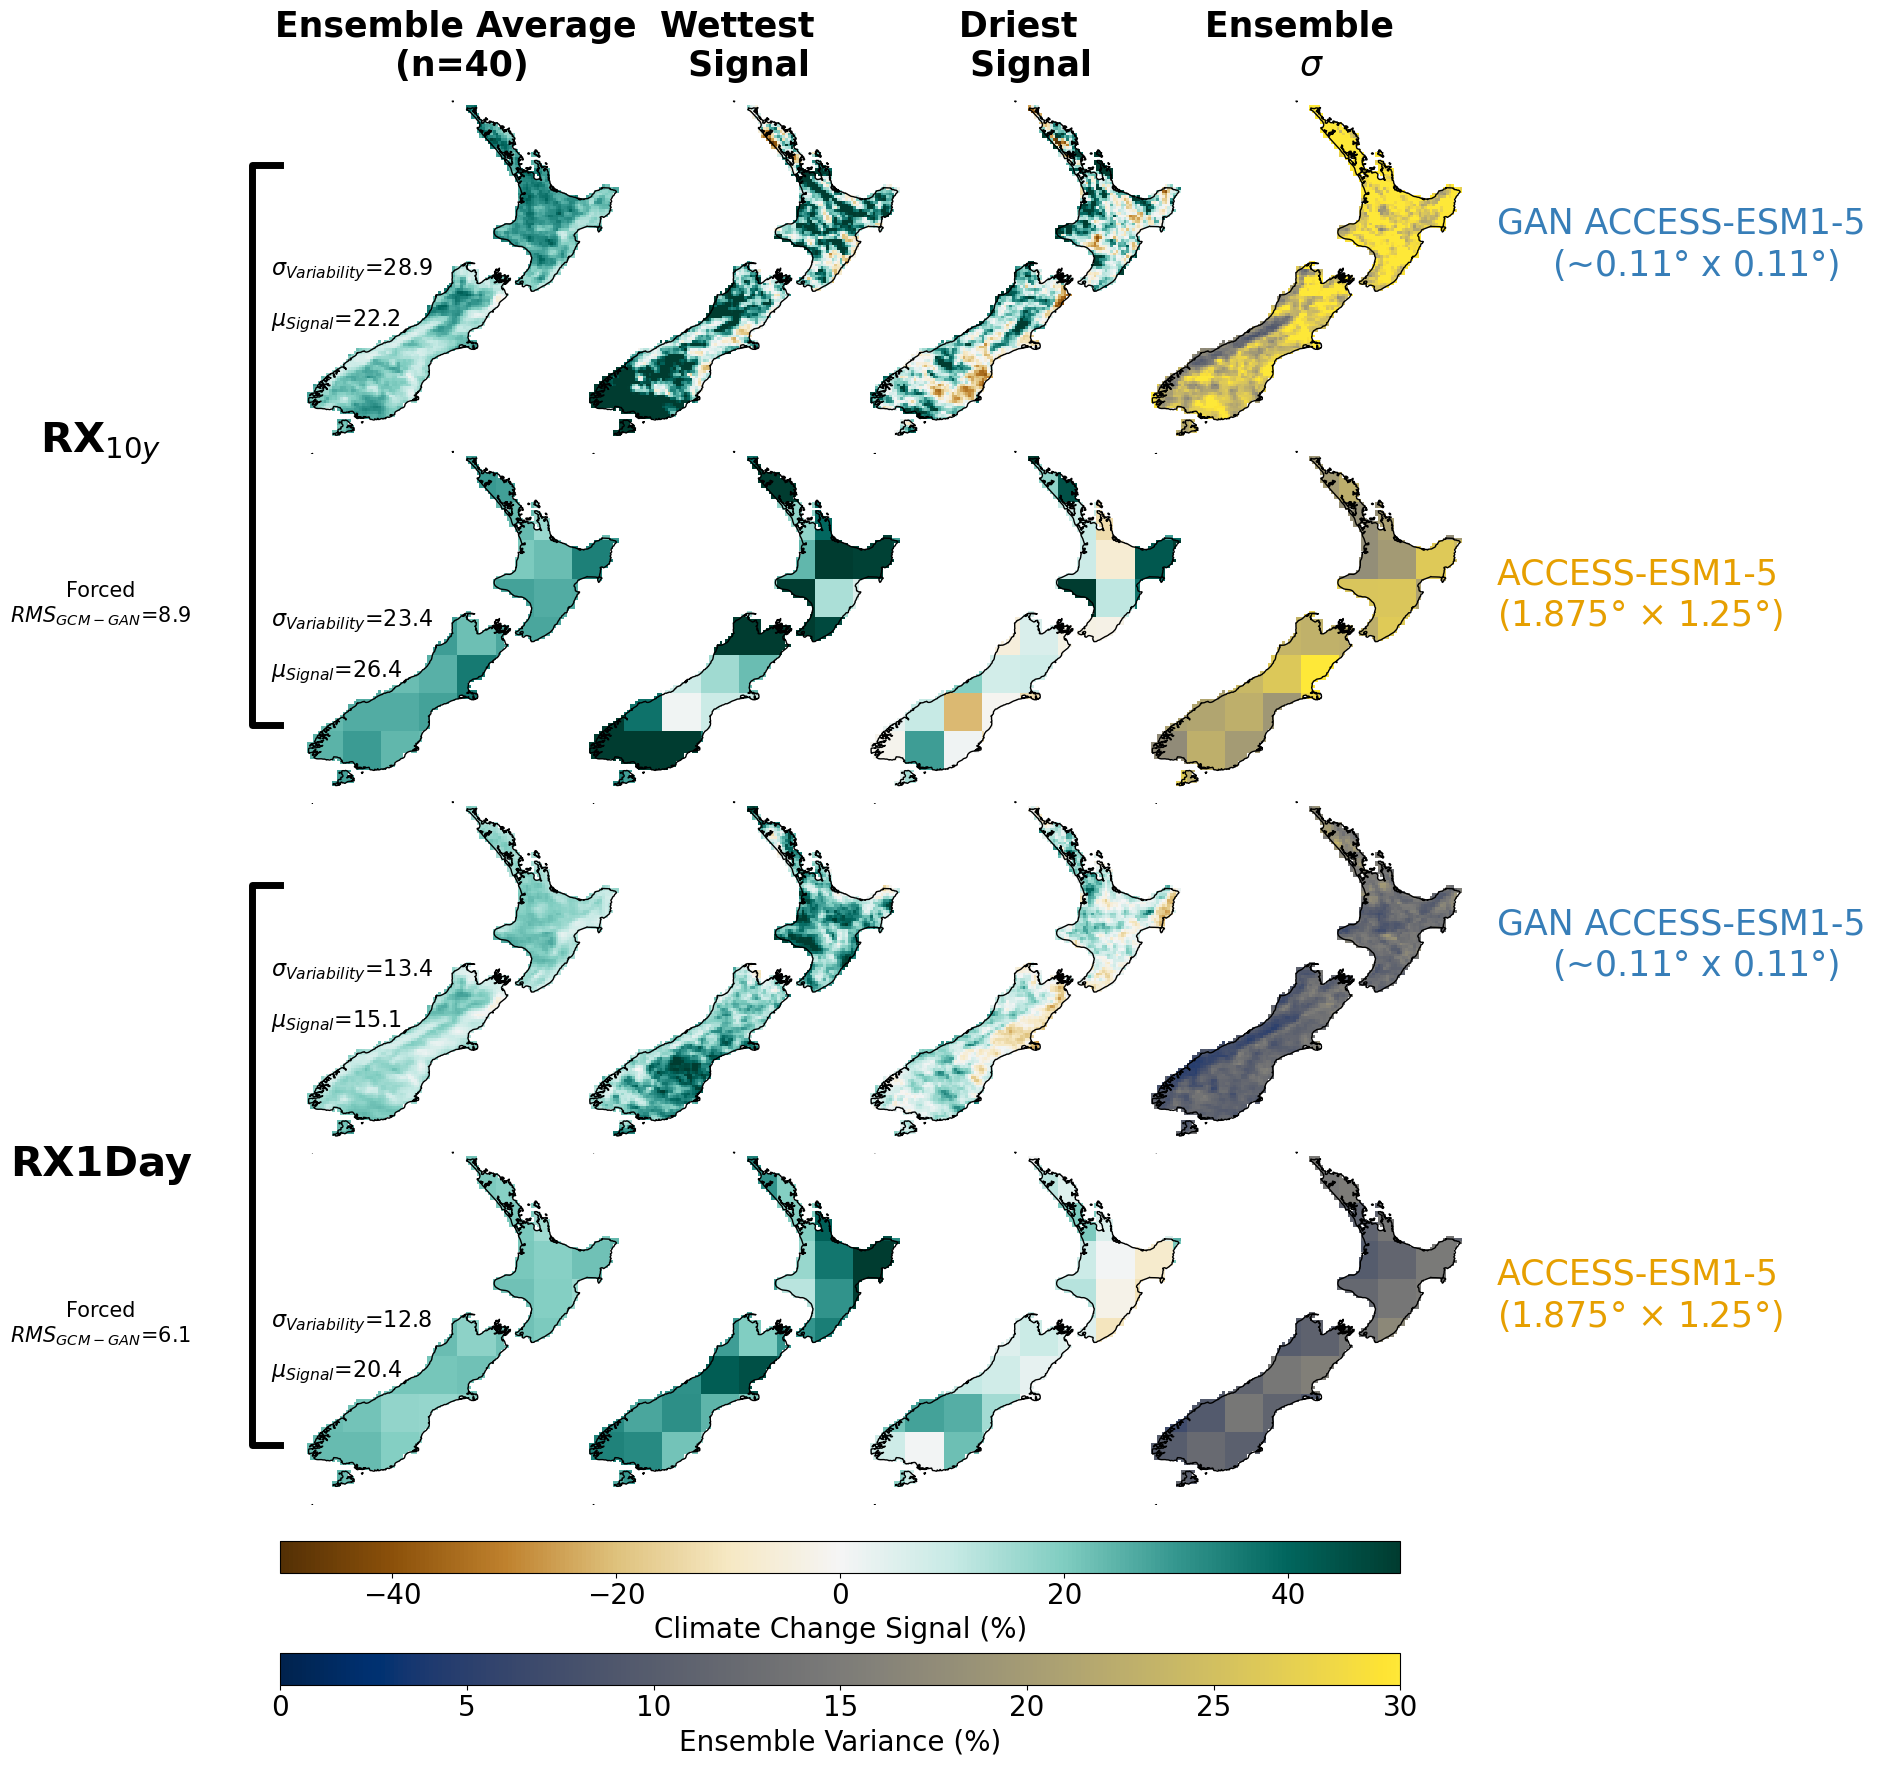

In [129]:
wettest_r10 = np.argmax(cc_signal_em_v2.where(static_fields.orog>0, np.nan).mean(["lat","lon"]).values)
driest_r10 = np.argmin(cc_signal_em_v2.where(static_fields.orog>0, np.nan).mean(["lat","lon"]).values)


wettest_r10_gcm = np.nanargmax(cc_signal_v2.where(static_fields.orog>0, np.nan).mean(["lat","lon"]).values)
driest_r10_gcm = np.nanargmin(cc_signal_v2.where(static_fields.orog>0, np.nan).mean(["lat","lon"]).values)


wettest_gcm = np.nanargmax(cc_signal.where(static_fields.orog>0, np.nan).mean(["lat","lon"]).values)
driest_gcm = np.nanargmin(cc_signal.where(static_fields.orog>0, np.nan).mean(["lat","lon"]).values)
wettest = np.argmax(cc_signal_em.where(static_fields.orog>0, np.nan).mean(["lat","lon"]).values)
driest = np.argmin(cc_signal_em.where(static_fields.orog>0, np.nan).mean(["lat","lon"]).values)

fig, ax = plt.subplots(4,4, subplot_kw = dict(projection = ccrs.PlateCarree(central_longitude =171.77)), figsize = (14, 16),sharex=True,sharey=True)
#hillshade_dset.hillshade.plot(ax = ax[0,0], cmap ='Greys_r', alpha =0.25, levels =50, zorder =4, add_colorbar =False, transform =ccrs.PlateCarree())
vmin =-50
vmax =50
cmap_uncertainty ='cividis'
cc_signal_em_v2.where(static_fields.orog>0, np.nan).mean("GCM_variant").plot(ax = ax[0,0], transform = ccrs.PlateCarree(), add_colorbar =False, cmap ='BrBG', zorder =3, alpha =1, vmin =vmin, vmax =vmax)
ax[0,0].text(165, -41, '$\sigma_{Variability}$=' + f'{"%.1f" % cc_signal_em_v2.where(static_fields.orog>0, np.nan).std(["GCM_variant","lat","lon"])}', transform = ccrs.PlateCarree(), fontsize =16)
ax[0,0].text(165, -43, '$\mu_{Signal}$=' + f'{"%.1f" % cc_signal_em_v2.where(static_fields.orog>0, np.nan).mean("GCM_variant").mean(["lat","lon"])}', transform = ccrs.PlateCarree(), fontsize =16)
cc_signal_v2.mean("GCM_variant").where(static_fields.orog>0, np.nan).plot(ax = ax[1,0], transform = ccrs.PlateCarree(), add_colorbar =False, cmap ='BrBG', vmin =vmin, vmax =vmax)
ax[1,0].text(165, -41, '$\sigma_{Variability}$=' + f'{"%.1f" % cc_signal_v2.where(static_fields.orog>0, np.nan).std(["GCM_variant","lat","lon"])}', transform = ccrs.PlateCarree(), fontsize =16)
ax[1,0].text(165, -43, '$\mu_{Signal}$=' + f'{"%.1f" % cc_signal_v2.where(static_fields.orog>0, np.nan).mean("GCM_variant").mean(["lat","lon"])}', transform = ccrs.PlateCarree(), fontsize =16)
cs22 = cc_signal_em_v2.std("GCM_variant").where(static_fields.orog>0, np.nan).plot(ax = ax[0,-1], transform = ccrs.PlateCarree(), add_colorbar =False, cmap =cmap_uncertainty, vmin =0, vmax =30)
cc_signal_em.std("GCM_variant").where(static_fields.orog>0, np.nan).plot(ax = ax[-2,-1], transform = ccrs.PlateCarree(), add_colorbar =False, cmap =cmap_uncertainty, vmin =0, vmax =30)

cc_signal_em_v2.where(static_fields.orog>0, np.nan).isel(GCM_variant = wettest_r10).plot(ax = ax[0,1], transform = ccrs.PlateCarree(), add_colorbar =False, cmap ='BrBG', vmin =vmin, vmax =vmax)
#cc_signal_v2.sel(GCM_variant = cc_signal_em_v2.GCM_variant.values[wettest_r10]).where(static_fields.orog>0, np.nan).plot(ax = ax[1,1], transform = ccrs.PlateCarree(), add_colorbar =False, cmap ='BrBG', vmin =vmin, vmax =vmax)
cc_signal_v2.isel(GCM_variant = wettest_r10_gcm).where(static_fields.orog>0, np.nan).plot(ax = ax[1,1], transform = ccrs.PlateCarree(), add_colorbar =False, cmap ='BrBG', vmin =vmin, vmax =vmax)
cc_signal_v2.isel(GCM_variant = driest_r10_gcm).where(static_fields.orog>0, np.nan).plot(ax = ax[1,2], transform = ccrs.PlateCarree(), add_colorbar =False, cmap ='BrBG', vmin =vmin, vmax =vmax)

#cc_signal_v2.sel(GCM_variant = cc_signal_em_v2.GCM_variant.values[driest_r10]).where(static_fields.orog>0, np.nan).plot(ax = ax[1,2], transform = ccrs.PlateCarree(), add_colorbar =False, cmap ='BrBG', vmin =vmin, vmax =vmax)
cc_signal_em_v2.where(static_fields.orog>0, np.nan).isel(GCM_variant = driest_r10).plot(ax = ax[0,2], transform = ccrs.PlateCarree(), add_colorbar =False, cmap ='BrBG', vmin =vmin, vmax =vmax)
cc_signal_v2.std("GCM_variant").where(static_fields.orog>0, np.nan).plot(ax = ax[1,-1], transform = ccrs.PlateCarree(), add_colorbar =False, cmap =cmap_uncertainty, vmin =0, vmax =30)
cc_signal.std("GCM_variant").where(static_fields.orog>0, np.nan).plot(ax = ax[-1,-1], transform = ccrs.PlateCarree(), add_colorbar =False, cmap =cmap_uncertainty, vmin =0, vmax =30)


cc_signal_em.where(static_fields.orog>0, np.nan).mean("GCM_variant").plot(ax = ax[2,0], transform = ccrs.PlateCarree(), add_colorbar =False, cmap ='BrBG', vmin =vmin, vmax =vmax)
ax[2,0].text(165, -41, '$\sigma_{Variability}$=' + f'{"%.1f" % cc_signal_em.where(static_fields.orog>0, np.nan).std(["GCM_variant","lat","lon"])}', transform = ccrs.PlateCarree(), fontsize =16)
ax[2,0].text(165, -43, '$\mu_{Signal}$=' + f'{"%.1f" % cc_signal_em.where(static_fields.orog>0, np.nan).mean("GCM_variant").mean(["lat","lon"])}', transform = ccrs.PlateCarree(), fontsize =16)
cs1 = cc_signal_em.where(static_fields.orog>0, np.nan).isel(GCM_variant = wettest).plot(ax = ax[2,1], transform = ccrs.PlateCarree(), add_colorbar =False, cmap ='BrBG', vmin =vmin, vmax =vmax)
cc_signal_em.where(static_fields.orog>0, np.nan).isel(GCM_variant = driest).plot(ax = ax[2,2], transform = ccrs.PlateCarree(), add_colorbar =False, cmap ='BrBG', vmin =vmin, vmax = vmax)
#cc_signal.sel(GCM_variant = cc_signal_em.GCM_variant.values[wettest]).where(static_fields.orog>0, np.nan).plot(ax = ax[3,1], transform = ccrs.PlateCarree(), add_colorbar =False, cmap ='BrBG', vmin =vmin, vmax =vmax)
cc_signal.mean("GCM_variant").where(static_fields.orog>0, np.nan).plot(ax = ax[3,0], transform = ccrs.PlateCarree(), add_colorbar =False, cmap ='BrBG', vmin =vmin, vmax =vmax)
ax[3,0].text(165, -41, '$\sigma_{Variability}$=' + f'{"%.1f" % cc_signal.where(static_fields.orog>0, np.nan).std(["GCM_variant","lat","lon"])}', transform = ccrs.PlateCarree(), fontsize =16)
ax[3,0].text(165, -43, '$\mu_{Signal}$=' + f'{"%.1f" % cc_signal.where(static_fields.orog>0, np.nan).mean("GCM_variant").mean(["lat","lon"])}', transform = ccrs.PlateCarree(), fontsize =16)
cc_signal.isel(GCM_variant = wettest_gcm).where(static_fields.orog>0, np.nan).plot(ax = ax[3,1], transform = ccrs.PlateCarree(), add_colorbar =False, cmap ='BrBG', vmin =vmin, vmax =vmax)

cc_signal.isel(GCM_variant = driest_gcm).where(static_fields.orog>0, np.nan).where(static_fields.orog>0, np.nan).plot(ax = ax[3,2], transform = ccrs.PlateCarree(), add_colorbar =False, cmap ='BrBG', vmin =vmin, vmax=vmax)

#cc_signal.sel(GCM_variant = cc_signal_em.GCM_variant.values[driest]).where(static_fields.orog>0, np.nan).where(static_fields.orog>0, np.nan).plot(ax = ax[3,2], transform = ccrs.PlateCarree(), add_colorbar =False, cmap ='BrBG', vmin =vmin, vmax=vmax)
[ax[i,j].set_title(' ') for i in range(4) for j in range(4)]
[ax[i,j].set_frame_on(False) for i in range(4) for j in range(4)]
ax[0,0].set_extent([165, 180, -48, -33.5], crs = ccrs.PlateCarree())
ax[0,0].set_title('Ensemble Average \n(n=40)', fontsize =25, weight ='bold')
ax[0,1].set_title('Wettest \n Signal', fontsize =25, weight ='bold')
ax[0,2].set_title('Driest \n Signal', fontsize =25, weight ='bold')
ax[0,3].set_title('Ensemble \n $\sigma$', fontsize =25, weight ='bold')

[ax[i,j].coastlines('10m', zorder =8) for i in range(4) for j in range(4)]

# Remove extra space
fig.text(-0.078, 0.4 + (0.85 - 0.5)/2, "Forced\n$RMS_{GCM-GAN}$=" + f'{"%.1f" % np.sqrt(abs(cc_signal_v2.where(static_fields.orog>0, np.nan).mean("GCM_variant") - cc_signal_em_v2.where(static_fields.orog>0, np.nan).mean("GCM_variant"))**2).mean()}', fontsize=15, va='center', ha='center', rotation =0)

# Add text label ("JJA") on the left
fig.text(-0.078, 0.5 + (0.85 - 0.5)/2, "RX$_{10y}$", fontsize=30, va='center', ha='center', weight ='bold', rotation =0)

# Add thick bracket-like symbol
bracket_x = [0.05, 0.03, 0.03, 0.05]  # X-coordinates
bracket_y = [0.85, 0.85, 0.5, 0.5]  # Y-coordinates
ax5 = fig.add_axes([0, 0.5, 0.05, 0.4])

ax5.plot(bracket_x, bracket_y, transform=fig.transFigure, lw=5, color='black', clip_on=False)
ax5.set_frame_on(False)
ax5.set_yticks([])
ax5.set_xticks([])


gan_color = "#377EB8"  # Blue for GAN ACCESS-ESM1-5
esm_color = "#E69F00"  # Orange for ACCESS-ESM1-5

fig.text(-0.078, 0.05 + (0.4 - 0.05)/2, "RX1Day", fontsize=30, va='center', ha='center', weight ='bold', rotation =0)
fig.text(-0.078, -0.05 +  (0.4 - 0.05)/2, "Forced\n$RMS_{GCM-GAN}$=" + f'{"%.1f" % np.sqrt(abs(cc_signal.where(static_fields.orog>0, np.nan).mean("GCM_variant") - cc_signal_em.where(static_fields.orog>0, np.nan).mean("GCM_variant"))**2).mean()}', fontsize=15, va='center', ha='center', rotation =0)
# Add thick bracket-like symbol
bracket_x = [0.05, 0.03, 0.03, 0.05]  # X-coordinates
bracket_y = [0.4, 0.4, 0.05, 0.05]  # Y-coordinates
ax6 = fig.add_axes([0, 0.05, 0.05, 0.4])

ax6.plot(bracket_x, bracket_y, transform=fig.transFigure, lw=5, color='black', clip_on=False)
ax6.set_frame_on(False)
ax6.set_yticks([])
ax6.set_xticks([])
ax[0,-1].text(180, -41, 'GAN ACCESS-ESM1-5 \n     (~0.11$\degree$ x 0.11$\degree$)', fontsize =25, transform = ccrs.PlateCarree(), color =gan_color)
plt.subplots_adjust(left=0.0125, right=0.95, top=0.9, bottom=0.0125, wspace=-0.4, hspace=-0.05)
ax[1,-1].text(180, -41, 'ACCESS-ESM1-5 \n(1.875$\degree$ × 1.25$\degree$)', fontsize =25, transform = ccrs.PlateCarree(), color=esm_color)
ax[2,-1].text(180, -41, 'GAN ACCESS-ESM1-5 \n     (~0.11$\degree$ x 0.11$\degree$)', fontsize =25, transform = ccrs.PlateCarree(), color =gan_color)
ax[-1,-1].text(180, -41, 'ACCESS-ESM1-5 \n(1.875$\degree$ × 1.25$\degree$)', fontsize =25, transform = ccrs.PlateCarree(), color=esm_color)
ax7 = fig.add_axes([0.05, -0.03, 0.8, 0.02])
cbar = fig.colorbar(cs1, cax = ax7, orientation = 'horizontal')
cbar.set_label('Climate Change Signal (%)', fontsize =20)
cbar.ax.tick_params(labelsize =20)


ax8 = fig.add_axes([0.05, -0.1, 0.8, 0.02])
cbar2 = fig.colorbar(cs22, cax = ax8, orientation = 'horizontal')
cbar2.set_label('Ensemble Variance (%)', fontsize =20)
cbar2.ax.tick_params(labelsize =20)
#fig.tight_layout()
fig.savefig(r'/nesi/project/niwa00018/ML_downscaling_CCAM/AI_large_ensemble/Figure2_Deser_wettest_and_driest_plots_extreme_v190525.png', dpi =500, bbox_inches ='tight')
#fig.savefig(r'/nesi/project/niwa00018/ML_downscaling_CCAM/AI_large_ensemble/Figure2_Deser_wettest_and_driest_plots_extreme_v190525.pdf', dpi =300, bbox_inches ='tight')

In [130]:
wettest_r10 = np.argmax(cc_signal_em_txx_v2.where(static_fields.orog>0, np.nan).mean(["lat","lon"]).values)
driest_r10 = np.argmin(cc_signal_em_txx_v2.where(static_fields.orog>0, np.nan).mean(["lat","lon"]).values)
wettest = np.argmax(cc_signal_em_txx.where(static_fields.orog>0, np.nan).mean(["lat","lon"]).values)
driest = np.argmin(cc_signal_em_txx.where(static_fields.orog>0, np.nan).mean(["lat","lon"]).values)

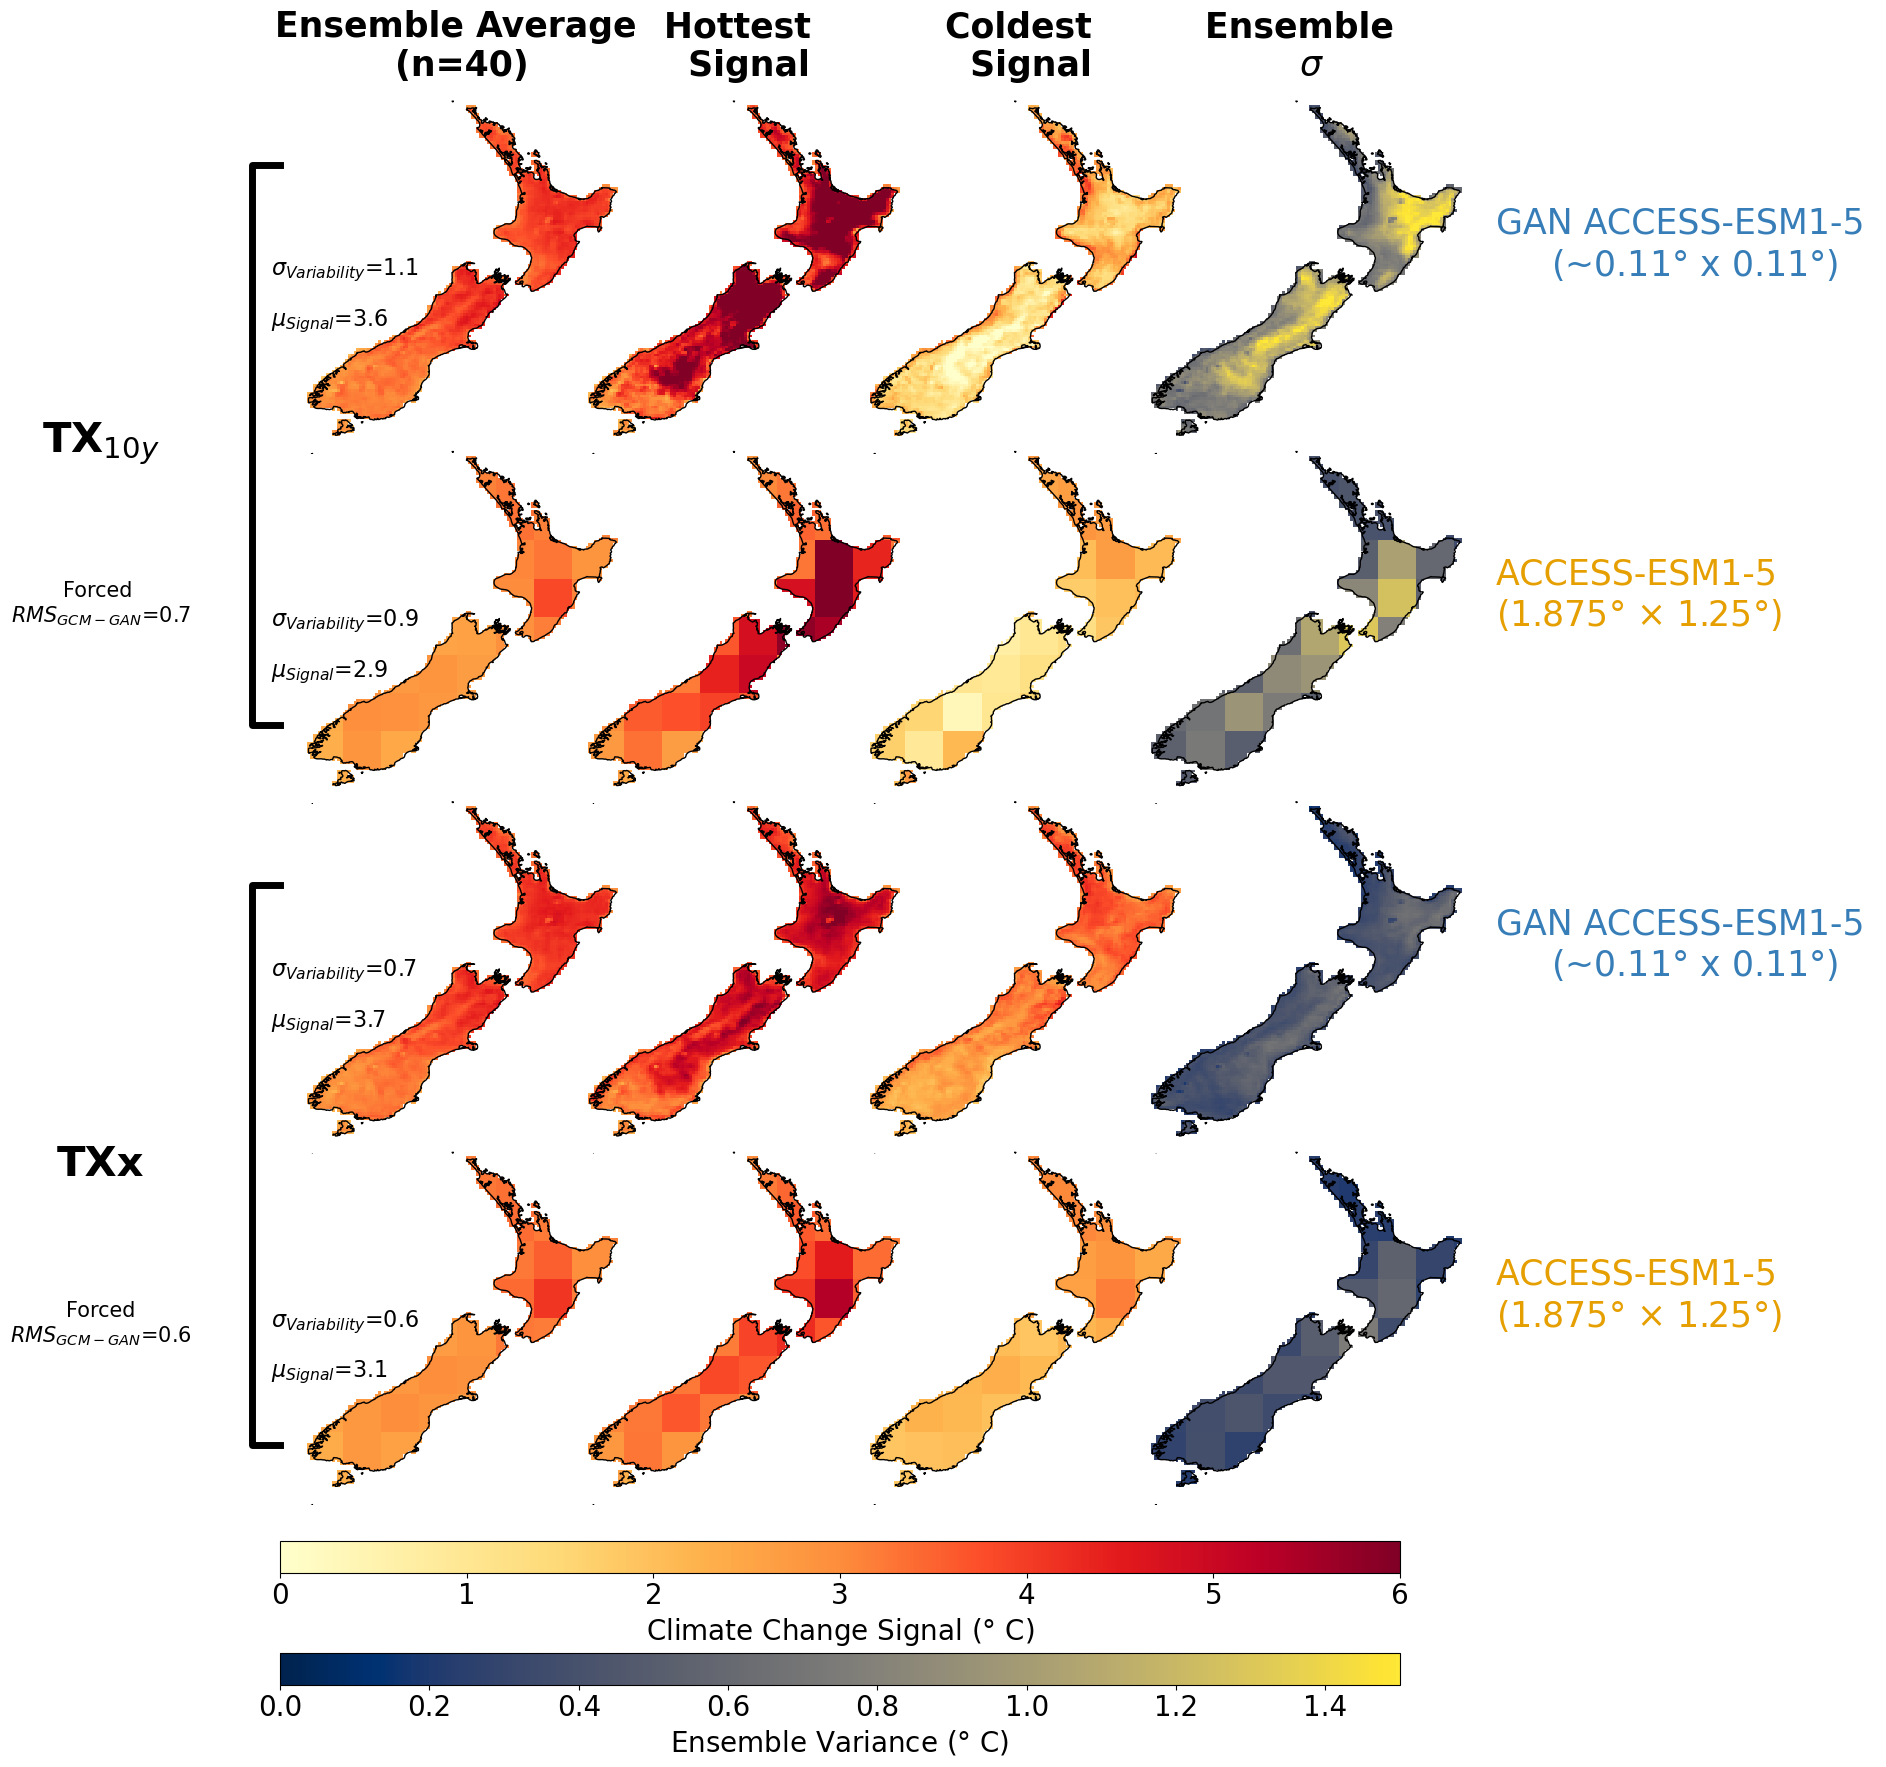

In [131]:


fig, ax = plt.subplots(4,4, subplot_kw = dict(projection = ccrs.PlateCarree(central_longitude =171.77)), figsize = (14, 16),sharex=True,sharey=True)
#hillshade_dset.hillshade.plot(ax = ax[0,0], cmap ='Greys_r', alpha =0.25, levels =50, zorder =4, add_colorbar =False, transform =ccrs.PlateCarree())
vmin =0
vmax =6
cmap = 'YlOrRd'
cmap_uncertainty ='cividis'
cc_signal_em_txx_v2.where(static_fields.orog>0, np.nan).mean("GCM_variant").plot(ax = ax[0,0], transform = ccrs.PlateCarree(), add_colorbar =False, cmap =cmap, zorder =3, alpha =1, vmin =vmin, vmax =vmax)
cc_signal_txx_v2.mean("GCM_variant").where(static_fields.orog>0, np.nan).plot(ax = ax[1,0], transform = ccrs.PlateCarree(), add_colorbar =False, cmap =cmap, vmin =vmin, vmax =vmax)

ax[0,0].text(165, -41, '$\sigma_{Variability}$=' + f'{"%.1f" % cc_signal_em_txx_v2.where(static_fields.orog>0, np.nan).std(["GCM_variant","lat","lon"])}', transform = ccrs.PlateCarree(), fontsize =16)
ax[0,0].text(165, -43, '$\mu_{Signal}$=' + f'{"%.1f" % cc_signal_em_txx_v2.where(static_fields.orog>0, np.nan).mean("GCM_variant").mean(["lat","lon"])}', transform = ccrs.PlateCarree(), fontsize =16)
cs22 = cc_signal_em_txx_v2.std("GCM_variant").where(static_fields.orog>0, np.nan).plot(ax = ax[0,-1], transform = ccrs.PlateCarree(), add_colorbar =False, cmap =cmap_uncertainty, vmin =0, vmax =1.5)
cc_signal_em_txx.std("GCM_variant").where(static_fields.orog>0, np.nan).plot(ax = ax[-2,-1], transform = ccrs.PlateCarree(), add_colorbar =False, cmap =cmap_uncertainty, vmin =0, vmax =1.5)

cc_signal_em_txx_v2.where(static_fields.orog>0, np.nan).isel(GCM_variant = wettest_r10).plot(ax = ax[0,1], transform = ccrs.PlateCarree(), add_colorbar =False, cmap =cmap, vmin =vmin, vmax =vmax)
cc_signal_txx_v2.sel(GCM_variant = cc_signal_em_txx_v2.GCM_variant.values[wettest_r10]).where(static_fields.orog>0, np.nan).plot(ax = ax[1,1], transform = ccrs.PlateCarree(), add_colorbar =False, cmap =cmap, vmin =vmin, vmax =vmax)
ax[1,0].text(165, -41, '$\sigma_{Variability}$=' + f'{"%.1f" % cc_signal_txx_v2.where(static_fields.orog>0, np.nan).std(["GCM_variant","lat","lon"])}', transform = ccrs.PlateCarree(), fontsize =16)
ax[1,0].text(165, -43, '$\mu_{Signal}$=' + f'{"%.1f" % cc_signal_txx_v2.where(static_fields.orog>0, np.nan).mean("GCM_variant").mean(["lat","lon"])}', transform = ccrs.PlateCarree(), fontsize =16)
cc_signal_txx_v2.sel(GCM_variant = cc_signal_em_txx_v2.GCM_variant.values[driest_r10]).where(static_fields.orog>0, np.nan).plot(ax = ax[1,2], transform = ccrs.PlateCarree(), add_colorbar =False, cmap =cmap, vmin =vmin, vmax =vmax)
cc_signal_em_txx_v2.where(static_fields.orog>0, np.nan).isel(GCM_variant = driest_r10).plot(ax = ax[0,2], transform = ccrs.PlateCarree(), add_colorbar =False, cmap =cmap, vmin =vmin, vmax =vmax)
cc_signal_txx_v2.std("GCM_variant").where(static_fields.orog>0, np.nan).plot(ax = ax[1,-1], transform = ccrs.PlateCarree(), add_colorbar =False, cmap =cmap_uncertainty, vmin =0, vmax =1.5)
cc_signal_txx.std("GCM_variant").where(static_fields.orog>0, np.nan).plot(ax = ax[-1,-1], transform = ccrs.PlateCarree(), add_colorbar =False, cmap =cmap_uncertainty, vmin =0, vmax =1.5)


cc_signal_em_txx.where(static_fields.orog>0, np.nan).mean("GCM_variant").plot(ax = ax[2,0], transform = ccrs.PlateCarree(), add_colorbar =False, cmap =cmap, vmin =vmin, vmax =vmax)
cs1 = cc_signal_em_txx.where(static_fields.orog>0, np.nan).isel(GCM_variant = wettest).plot(ax = ax[2,1], transform = ccrs.PlateCarree(), add_colorbar =False, cmap =cmap, vmin =vmin, vmax =vmax)

ax[2,0].text(165, -41, '$\sigma_{Variability}$=' + f'{"%.1f" % cc_signal_em_txx.where(static_fields.orog>0, np.nan).std(["GCM_variant","lat","lon"])}', transform = ccrs.PlateCarree(), fontsize =16)
ax[2,0].text(165, -43, '$\mu_{Signal}$=' + f'{"%.1f" % cc_signal_em_txx.where(static_fields.orog>0, np.nan).mean("GCM_variant").mean(["lat","lon"])}', transform = ccrs.PlateCarree(), fontsize =16)
cc_signal_em_txx.where(static_fields.orog>0, np.nan).isel(GCM_variant = driest).plot(ax = ax[2,2], transform = ccrs.PlateCarree(), add_colorbar =False, cmap =cmap, vmin =vmin, vmax = vmax)
cc_signal_txx.sel(GCM_variant = cc_signal_em_txx.GCM_variant.values[wettest]).where(static_fields.orog>0, np.nan).plot(ax = ax[3,1], transform = ccrs.PlateCarree(), add_colorbar =False, cmap =cmap, vmin =vmin, vmax =vmax)

cc_signal_txx.mean("GCM_variant").where(static_fields.orog>0, np.nan).plot(ax = ax[3,0], transform = ccrs.PlateCarree(), add_colorbar =False, cmap =cmap, vmin =vmin, vmax =vmax)
cc_signal_txx.sel(GCM_variant = cc_signal_em_txx.GCM_variant.values[driest]).where(static_fields.orog>0, np.nan).where(static_fields.orog>0, np.nan).plot(ax = ax[3,2], transform = ccrs.PlateCarree(), add_colorbar =False, cmap =cmap, vmin =vmin, vmax=vmax)

ax[3,0].text(165, -41, '$\sigma_{Variability}$=' + f'{"%.1f" % cc_signal_txx.where(static_fields.orog>0, np.nan).std(["GCM_variant","lat","lon"])}', transform = ccrs.PlateCarree(), fontsize =16)
ax[3,0].text(165, -43, '$\mu_{Signal}$=' + f'{"%.1f" % cc_signal_txx.where(static_fields.orog>0, np.nan).mean("GCM_variant").mean(["lat","lon"])}', transform = ccrs.PlateCarree(), fontsize =16)
[ax[i,j].set_title(' ') for i in range(4) for j in range(4)]
[ax[i,j].set_frame_on(False) for i in range(4) for j in range(4)]
ax[0,0].set_extent([165, 180, -48, -33.5], crs = ccrs.PlateCarree())
ax[0,0].set_title('Ensemble Average \n(n=40)', fontsize =25, weight ='bold')
ax[0,1].set_title('Hottest \n Signal', fontsize =25, weight ='bold')
ax[0,2].set_title('Coldest \n Signal', fontsize =25, weight ='bold')
ax[0,3].set_title('Ensemble \n $\sigma$', fontsize =25, weight ='bold')

[ax[i,j].coastlines('10m', zorder =8) for i in range(4) for j in range(4)]

# Remove extra space

fig.text(-0.078, 0.4 + (0.85 - 0.5)/2, "Forced \n$RMS_{GCM-GAN}$=" + f'{"%.1f" % np.sqrt(abs(cc_signal_txx_v2.where(static_fields.orog>0, np.nan).mean("GCM_variant") - cc_signal_em_txx_v2.where(static_fields.orog>0, np.nan).mean("GCM_variant"))**2).mean()}', fontsize=15, va='center', ha='center', rotation =0)

# Add text label ("JJA") on the left
fig.text(-0.078, 0.5 + (0.85 - 0.5)/2, "TX$_{10y}$", fontsize=30, va='center', ha='center', weight ='bold', rotation =0)

# Add thick bracket-like symbol
bracket_x = [0.05, 0.03, 0.03, 0.05]  # X-coordinates
bracket_y = [0.85, 0.85, 0.5, 0.5]  # Y-coordinates
ax5 = fig.add_axes([0, 0.5, 0.05, 0.4])

ax5.plot(bracket_x, bracket_y, transform=fig.transFigure, lw=5, color='black', clip_on=False)
ax5.set_frame_on(False)
ax5.set_yticks([])
ax5.set_xticks([])


gan_color = "#377EB8"  # Blue for GAN ACCESS-ESM1-5
esm_color = "#E69F00"  # Orange for ACCESS-ESM1-5

fig.text(-0.078, 0.05 + (0.4 - 0.05)/2, "TXx", fontsize=30, va='center', ha='center', weight ='bold', rotation =0)
fig.text(-0.078, -0.05 +  (0.4 - 0.05)/2, "Forced\n$RMS_{GCM-GAN}$=" + f'{"%.1f" % np.sqrt(abs(cc_signal_txx.where(static_fields.orog>0, np.nan).mean("GCM_variant") - cc_signal_em_txx.where(static_fields.orog>0, np.nan).mean("GCM_variant"))**2).mean()}', fontsize=15, va='center', ha='center', rotation =0)

# Add thick bracket-like symbol
bracket_x = [0.05, 0.03, 0.03, 0.05]  # X-coordinates
bracket_y = [0.4, 0.4, 0.05, 0.05]  # Y-coordinates
ax6 = fig.add_axes([0, 0.05, 0.05, 0.4])

ax6.plot(bracket_x, bracket_y, transform=fig.transFigure, lw=5, color='black', clip_on=False)
ax6.set_frame_on(False)
ax6.set_yticks([])
ax6.set_xticks([])
ax[0,-1].text(180, -41, 'GAN ACCESS-ESM1-5 \n     (~0.11$\degree$ x 0.11$\degree$)', fontsize =25, transform = ccrs.PlateCarree(), color =gan_color)
plt.subplots_adjust(left=0.0125, right=0.95, top=0.9, bottom=0.0125, wspace=-0.4, hspace=-0.05)
ax[1,-1].text(180, -41, 'ACCESS-ESM1-5 \n(1.875$\degree$ × 1.25$\degree$)', fontsize =25, transform = ccrs.PlateCarree(), color=esm_color)
ax[2,-1].text(180, -41, 'GAN ACCESS-ESM1-5 \n     (~0.11$\degree$ x 0.11$\degree$)', fontsize =25, transform = ccrs.PlateCarree(), color =gan_color)
ax[-1,-1].text(180, -41, 'ACCESS-ESM1-5 \n(1.875$\degree$ × 1.25$\degree$)', fontsize =25, transform = ccrs.PlateCarree(), color=esm_color)
ax7 = fig.add_axes([0.05, -0.03, 0.8, 0.02])
cbar = fig.colorbar(cs1, cax = ax7, orientation = 'horizontal')
cbar.set_label('Climate Change Signal ($\degree$ C)', fontsize =20)
cbar.ax.tick_params(labelsize =20)


ax8 = fig.add_axes([0.05, -0.1, 0.8, 0.02])
cbar2 = fig.colorbar(cs22, cax = ax8, orientation = 'horizontal')
cbar2.set_label('Ensemble Variance ($\degree$ C)', fontsize =20)
cbar2.ax.tick_params(labelsize =20)
#fig.tight_layout()
fig.savefig(r'/nesi/project/niwa00018/ML_downscaling_CCAM/AI_large_ensemble/Deser_hottest_and_coldest_plots_extreme.png', dpi =500, bbox_inches ='tight')
#fig.savefig(r'/nesi/project/niwa00018/ML_downscaling_CCAM/AI_large_ensemble/Deser_hottest_and_coldest_plots_extreme.pdf', dpi =300, bbox_inches ='tight')